In [232]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [233]:
adult_train = pd.read_csv('../Datasets/adult_train.csv', index_col=0)
adult_train.head()

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [234]:
adult_train = adult_train.replace({' ?':np.nan}).dropna()
adult_train = adult_train.reset_index(drop=True)
# df_train = adult_train[['education', 'occupation', 'marital-status', 'race', 'sex']]
df_train = adult_train[['education', 'occupation', 'race', 'sex']]
df_train_male = pd.get_dummies(df_train, drop_first=True)
df_train_female = df_train_male.copy()
df_train_female['sex_ Male'] = df_train_female['sex_ Male'].apply(lambda x : x^1)
train_target = pd.get_dummies(adult_train['target'], drop_first=True)

df_train_male.head()

,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,...,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0


In [237]:
model = RandomForestClassifier(random_state=0).fit(df_train_male.values, train_target.values.ravel())

prob = np.amax(model.predict_proba(df_train_male), axis=1)
prob_flip = np.amax(model.predict_proba(df_train_female), axis=1)

train_flip = df_train.copy()
male_index = train_flip.loc[train_flip['sex']==' Male'].index
female_index = train_flip.loc[train_flip['sex']==' Female'].index

In [243]:
diff = np.mean(prob[male_index]) - np.mean(prob[female_index])
diff_flip = np.mean(prob_flip[male_index]) - np.mean(prob_flip[female_index])
avg_effect = diff_flip - diff
print('average effect: ', avg_effect)

average effect:  0.2527428914706419


In [245]:
train_flip['effect'] = prob_flip - prob
train_flip['deviation'] = train_flip['effect'] - avg_effect
train_flip.sort_values('deviation', ascending=False).head()

,education,occupation,race,sex,effect,deviation
20250,Prof-school,Prof-specialty,Black,Male,0.496255,0.243513
29410,Prof-school,Prof-specialty,Black,Male,0.496255,0.243513
19944,Prof-school,Prof-specialty,Black,Male,0.496255,0.243513
5907,Prof-school,Prof-specialty,Black,Male,0.496255,0.243513
4069,Prof-school,Prof-specialty,Black,Male,0.496255,0.243513


In [247]:
import pysubgroup as ps

target = ps.NumericTarget('deviation')
searchSpace = ps.create_selectors(train_flip.drop('effect', axis=1), ignore=['deviation', "sex"])
task = ps.SubgroupDiscoveryTask (train_flip.drop('effect', axis=1), target, searchSpace, depth=4, qf=ps.StandardQF_numeric(1))
result = ps.BeamSearch().execute(task)
for (q, sg) in result:
    print (str(q) + ":\t" + str(sg.subgroup_description))

373.2954765895759:	occupation= Craft-repair
354.53694418158193:	race= White AND occupation= Craft-repair
191.21221531074414:	education= HS-grad AND occupation= Craft-repair
189.13674944770383:	race= White AND education= HS-grad AND occupation= Craft-repair
183.94702579225742:	race= White AND education= HS-grad
182.11464048623216:	race= White
157.26306398486813:	race= White AND education= Bachelors
150.48819590609853:	race= White AND education= Some-college
133.1330411610601:	education= HS-grad
132.4134516596848:	education= Bachelors


In [229]:
df = ps.resultsAsDataFrame(train_flip, result, statistics_to_show=ps.all_statistics_numeric)
df

,quality,subgroup,size_sg,size_dataset,mean_sg,mean_dataset,std_sg,std_dataset,median_sg,median_dataset,max_sg,max_dataset,min_sg,min_dataset,mean_lift,median_lift
0,373.295477,occupation= Craft-repair,4030.0,30162.0,-0.116824,-0.209453,0.145536,0.18226,-0.085926,-0.200008,0.216305,0.243513,-0.721791,-0.748998,0.557757,0.429613
1,354.536944,race= White AND occupation= Craft-repair,3644.0,30162.0,-0.112160,-0.209453,0.143607,0.18226,-0.085926,-0.200008,0.205420,0.243513,-0.710906,-0.748998,0.535489,0.429613
2,191.212215,education= HS-grad AND occupation= Craft-repair,1903.0,30162.0,-0.108974,-0.209453,0.072879,0.18226,-0.085926,-0.200008,-0.085926,0.243513,-0.419560,-0.748998,0.520277,0.429613
3,189.136749,race= White AND education= HS-grad AND occupat...,1731.0,30162.0,-0.100189,-0.209453,0.067492,0.18226,-0.085926,-0.200008,-0.085926,0.243513,-0.419560,-0.748998,0.478334,0.429613
4,183.947026,race= White AND education= HS-grad,8401.0,30162.0,-0.187557,-0.209453,0.141295,0.18226,-0.153985,-0.200008,0.015197,0.243513,-0.520682,-0.748998,0.895462,0.769897
5,182.114640,race= White,25933.0,30162.0,-0.202431,-0.209453,0.182809,0.18226,-0.186866,-0.200008,0.205420,0.243513,-0.710906,-0.748998,0.966472,0.934294
6,157.263064,race= White AND education= Bachelors,4448.0,30162.0,-0.174097,-0.209453,0.201862,0.18226,-0.191796,-0.200008,0.182024,0.243513,-0.687510,-0.748998,0.831199,0.958945
7,150.488196,race= White AND education= Some-college,5705.0,30162.0,-0.183075,-0.209453,0.200432,0.18226,-0.135603,-0.200008,0.072205,0.243513,-0.577690,-0.748998,0.874061,0.677991
8,133.133041,education= HS-grad,9840.0,30162.0,-0.195923,-0.209453,0.143203,0.18226,-0.168693,-0.200008,0.230590,0.243513,-0.736076,-0.748998,0.935404,0.843433
9,132.413452,education= Bachelors,5044.0,30162.0,-0.183201,-0.209453,0.207711,0.18226,-0.200749,-0.200008,0.205590,0.243513,-0.711076,-0.748998,0.874666,1.003709


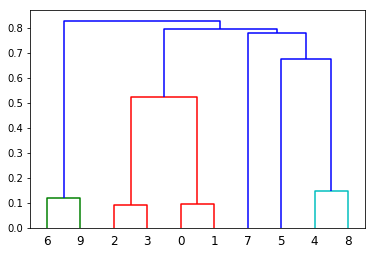

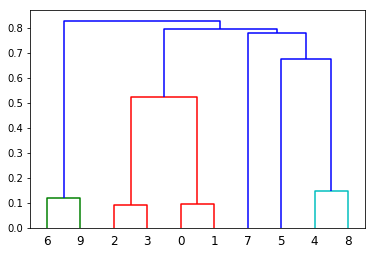

In [248]:
ps.similarity_dendrogram(result, train_flip)


In [231]:
ps.similarity_sgs(result, train_flip)

,0,1,2,3,4,5,6,7,8,9
0,1,0.904218,0.472208,0.429529,0.161776,0.138455,0.0236658,0.0852843,0.159021,0.0248475
1,0.904218,1,0.453616,0.475027,0.16783,0.140516,0.0248227,0.0891193,0.147282,0.0230805
2,0.472208,0.453616,1,0.909616,0.201913,0.0663091,0,0,0.193394,0
3,0.429529,0.475027,0.909616,1,0.206047,0.0667489,0,0,0.175915,0
4,0.161776,0.16783,0.201913,0.206047,1,0.32395,0,0,0.85376,0
5,0.138455,0.140516,0.0663091,0.0667489,0.32395,1,0.171519,0.21999,0.306919,0.167666
6,0.0236658,0.0248227,0,0,0,0.171519,1,0,0,0.88184
7,0.0852843,0.0891193,0,0,0,0.21999,0,1,0,0
8,0.159021,0.147282,0.193394,0.175915,0.85376,0.306919,0,0,1,0
9,0.0248475,0.0230805,0,0,0,0.167666,0.88184,0,0,1
